In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
import scipy as sp
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.cluster import DBSCAN
import random
from kmodes.kmodes import KModes

In [2]:
# IMPORT DATA

df = pd.read_json('yelp_dataset/yelp_academic_dataset_business.json', lines=True)
print(df)


                   business_id                     name               address  \
0       6iYb2HFDywm3zjuRg0shjw      Oskar Blues Taproom          921 Pearl St   
1       tCbdrRPZA0oiIYSmHG3J0w  Flying Elephants at PDX   7000 NE Airport Way   
2       bvN78flM8NLprQ1a1y5dRg           The Reclaimory    4720 Hawthorne Ave   
3       oaepsyvc0J17qwi8cfrOWg              Great Clips    2566 Enterprise Rd   
4       PE9uqAjdw0E4-8mjGl3wVA        Crossfit Terminus   1046 Memorial Dr SE   
...                        ...                      ...                   ...   
160580  D2mHoIDXx9N8mS1pGoKV9Q       Eleven Oaks Realty                         
160581  bQX-kwVTyZgcdZGEPzce6Q             Webb's Honey    21777 State Rd 520   
160582  wvFZ06nmPmQ2-IVoPqVYLA    Painting with a Twist  2164 S Chickasaw Trl   
160583  GB75wPibj3IjNauaoCxyGA              Havana Cafe        910 NW 14th St   
160584  ngmLL5Y5OT-bYHKU0kKrYA              Zora Grille   1370 E Altamonte Dr   

                     city s

In [3]:
# CLEAN DATA

n = 10
print(df['state'].value_counts()[:n].index.tolist())


df_filtered = df[(df['state']=='MA')]
df_cluster = df_filtered.filter(items=['business_id','latitude','longitude','categories', 'review_count', 'stars'])
df_filtered = df_filtered.filter(items=['business_id','name','address','city','state','stars','review_count','is_open','attributes','categories'])

print(df_filtered)
print(df_filtered.shape[0])




['MA', 'OR', 'TX', 'FL', 'GA', 'BC', 'OH', 'CO', 'WA', 'CA']
                   business_id                                 name  \
11      hCABMnKtwo4Y9alQDxh2kw         Star Kreations Salon and Spa   
12      HPA_qyMEddpAEtFof02ixg                  Mr G's Pizza & Subs   
18      6fT0lYr_UgWSCZs_w1PBTQ                        Salter School   
26      hcRxdDg7DYryCxCoI8ySQA                    Longwood Galleria   
29      jGennaZUr2MsJyRhijNBfA                      Legal Sea Foods   
...                        ...                                  ...   
160556  87f7kR7nTz8WHnmtLM_S6w                                 O Ya   
160563  yQL8SrSETbbCI1U5esVJQw                  Ciao! Pizza & Pasta   
160568  hX-wc8LoHWSWjBwZ84ANcg          Chestnut Green Dental Group   
160569  _-nynGfhsMVVWWbAZ6YhTw                        The Jury Room   
160579  d6iEdtgLKelWKtb-2UmE2A  Master Finish Mobile Auto Detailing   

                       address     city state  stars  review_count  is_open  \
11     

## Cluster based on location

In [7]:
df_cluster

,business_id,latitude,longitude,categories,review_count,stars
11,hCABMnKtwo4Y9alQDxh2kw,42.534248,-70.990948,"Wigs, Hair Extensions, Hair Salons, Blow Dry/O...",8,4.0
12,HPA_qyMEddpAEtFof02ixg,42.541155,-70.973438,"Food, Pizza, Restaurants",39,4.0
18,6fT0lYr_UgWSCZs_w1PBTQ,42.427889,-71.073475,"Specialty Schools, Massage Schools, Middle Sch...",5,2.0
26,hcRxdDg7DYryCxCoI8ySQA,42.338544,-71.106842,"Restaurants, Shopping, Shopping Centers",24,2.5
29,jGennaZUr2MsJyRhijNBfA,42.363442,-71.025781,"Sandwiches, Food, Restaurants, Breakfast & Bru...",856,3.5
...,...,...,...,...,...,...
160556,87f7kR7nTz8WHnmtLM_S6w,42.351408,-71.056867,"Japanese, Sushi Bars, Restaurants",737,4.5
160563,yQL8SrSETbbCI1U5esVJQw,42.389221,-71.040882,"Restaurants, Pizza, Italian",733,5.0
160568,hX-wc8LoHWSWjBwZ84ANcg,42.550054,-70.944788,"Health & Medical, Dentists, General Dentistry",6,3.0
160569,_-nynGfhsMVVWWbAZ6YhTw,42.249118,-71.001071,"Restaurants, American (New), Nightlife",30,3.0


In [8]:
df_location = df_cluster.filter(items= ['latitude','longitude'])
df_location

,latitude,longitude
11,42.534248,-70.990948
12,42.541155,-70.973438
18,42.427889,-71.073475
26,42.338544,-71.106842
29,42.363442,-71.025781
...,...,...
160556,42.351408,-71.056867
160563,42.389221,-71.040882
160568,42.550054,-70.944788
160569,42.249118,-71.001071


In [9]:
db = DBSCAN(eps=0.00005, min_samples=3, algorithm='ball_tree', metric='haversine').fit(np.radians(df_location))

In [10]:
labels = db.labels_

In [11]:
labels

array([ 0,  1,  2, ..., 19,  6, -1])

In [12]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

In [13]:
-1 in labels

True

In [14]:
df_location.iloc(0)[2]['latitude']

42.427889

In [15]:
len(colors)

444

In [16]:
labels[1]
random.shuffle(colors)

Plotting for location clusters

/var/folders/22/yn6463hn3gl4tmn8ckzyxcb40000gn/T/ipykernel_13336/4157913855.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x,y,'ro',color=c, markeredgecolor = 'k')


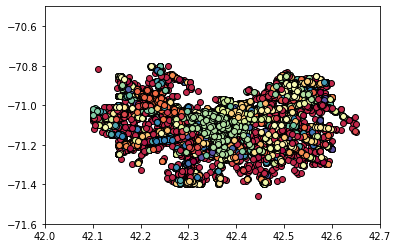

In [17]:
plt.xlim(42,42.7)
plt.ylim(-71.6,-70.5)
for i in range(0,len(labels)):
    if(labels[i] == -1):
       c = [0,0,0,1]
    c = colors[labels[i]]
    x = df_location.iloc(0)[i]['latitude']
    y = df_location.iloc(0)[i]['longitude']
    plt.plot(x,y,'ro',color=c, markeredgecolor = 'k')

Generate list of dataframe, each containing a cluster

In [18]:
cluster_list = [None] * len(set(labels))
for i in range(0,len(labels)):
    index = labels[i]
    if index != -1:
        if cluster_list[index] == None:
            cluster_list[index] = []
            cluster_list[index].append(df_cluster.iloc(0)[i])
        else:
            cluster_list[index].append(df_cluster.iloc(0)[i])

In [19]:
for i in range(0, len(cluster_list)):
    df_new = pd.DataFrame(cluster_list[i])
    cluster_list[i] = df_new

In [20]:
t = np.array(cluster_list[0]['categories']).tolist()

In [21]:
for i in range(0,len(t)):
    text = t[i]
    t[i] = [x.strip() for x in text.split(',')]


In [22]:
unique_categories = list(set(i for j in t for i in j))
df_test = pd.DataFrame(index = range(0,len(t)), columns = unique_categories)

In [23]:
for i in range(0,len(t)):
    for each in t[i]:
        df_test.loc[i,each] = each
df_test.loc[0,'Wigs']
df_test.isnull().values.any()
df_test
df_test.shape

(135, 223)

In [24]:
while(df_test.isnull().values.any()==True):
    df_test.fillna(str(random.random() * 10000),inplace=True,limit=1)

In [25]:
km = KModes(n_clusters=50, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(df_test)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 18717.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 18718.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 3, cost: 18706.0
Run 3, iteration: 2/100, moves: 0, cost: 18706.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 18724.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 18728.0
Best run was number 3


In [26]:
l = [None] * len(set(clusters))
for i in range(0,len(clusters)):
    index = clusters[i]
    if index != -1:
        if l[index] == None:
            l[index] = []
            l[index].append(cluster_list[0].iloc(0)[i])
        else:
            l[index].append(cluster_list[0].iloc(0)[i])


## Clustering for each location cluster

The result is expected to be a list, with each element as a list of clusters. 

In [27]:
res = []
for i in range(0,len(cluster_list)):
    t = np.array(cluster_list[i]['categories']).tolist()
    for j in range(0,len(t)):
        text = t[j]
        if(text == None):
            text = 'None'
        t[j] = [x.strip() for x in text.split(',')]
    unique_categories = list(set(k for j in t for k in j))
    df_test = pd.DataFrame(index = range(0,len(t)), columns = unique_categories)
    for j in range(0,len(t)):
        for each in t[j]:
            df_test.loc[j,each] = each
    while(df_test.isnull().values.any()==True):
        df_test.fillna(str(random.random() * 10000),inplace=True,limit=1)
    km = KModes(n_clusters=int(min(df_test.shape[0]/3,50)), init='Huang', n_init=5, verbose=1)
    clusters = km.fit_predict(df_test)
    l = [None] * len(set(clusters))
    for j in range(0,len(clusters)):
        index = clusters[j]
        if index != -1:
            if l[index] == None:
                l[index] = []
                l[index].append(cluster_list[i].iloc(0)[j])
            else:
                l[index].append(cluster_list[i].iloc(0)[j])
    res.append(l)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1, cost: 19818.0
Run 1, iteration: 2/100, moves: 0, cost: 19818.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 19830.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 19810.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 19820.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 19821.0
Best run was number 3
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 249.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 246.0
Init: initializing centroids
I

KeyboardInterrupt: 

In [28]:
cluster_list[2]

,business_id,latitude,longitude,categories,review_count,stars
18,6fT0lYr_UgWSCZs_w1PBTQ,42.427889,-71.073475,"Specialty Schools, Massage Schools, Middle Sch...",5,2.0
226,_Z9-V7ezxypc3yNOHEuA-Q,42.452588,-71.066523,"Automotive, Auto Repair, Tires, Transmission R...",13,3.0
228,SHHxhkzbKBKvv2Mqe2Ylrw,42.468583,-71.068174,"Restaurants, Breakfast & Brunch, American (Tra...",45,4.5
730,4h9CoIcYjymGPaZz9v98BA,42.452132,-71.068069,"Home Services, Apartments, Real Estate",5,5.0
963,cLPou2isIKgOp3vb4Vpevw,42.456800,-71.065534,"Business Law, Lawyers, Professional Services, ...",5,5.0
...,...,...,...,...,...,...
160222,QgHRpCqXaBnD9SG9f16o9g,42.430338,-71.040307,"Car Rental, Hotels & Travel",14,3.0
160308,2w-NDtW_3JAMveWTpLBJXg,42.436523,-71.071569,"Beauty & Spas, Barbers",8,5.0
160367,XgKU6p8qPWm83QGwE_FD8w,42.455401,-71.064866,"Health & Medical, Optometrists",7,3.0
160466,RqCwjZ0SLXcWN8JpHWJGag,42.451278,-71.067308,"Medical Spas, Health & Medical, Nail Salons, B...",34,4.0


# Assigning Labels

In [29]:
# Example data for testing
clustered_df = pd.DataFrame(res[0][0])
clustered_df

,business_id,latitude,longitude,categories,review_count,stars
12992,PqjMauK9nKYWdxzvXCMv4g,42.548111,-70.984516,"Pets, Dog Walkers, Pet Sitting, Pet Groomers, ...",9,5.0
22600,L2rfv2_Eww8BpKTHxiGYxA,42.537126,-70.989183,"Pet Boarding, Pet Stores, Pet Sitting, Pet Ser...",20,5.0
34541,ANwm3ELINhJzKvcUTYTMKQ,42.536378,-70.989787,"Restaurants, Vietnamese",189,4.0
39273,OEIIgrgvjaXN9ov08kHeUA,42.547562,-70.979246,"Chinese, Restaurants",63,3.0
44130,5uMJpJA1y310CcMA4w8FmA,42.537126,-70.989183,"Pet Groomers, Pet Sitting, Pet Training, Pets,...",17,3.5
98958,VhuBKe0p0BFpo5vM7RvHTQ,42.534779,-70.991535,"Restaurants, Soup, Chinese, Food, Seafood, Cof...",101,3.5
103854,1hgWd6n_amooZLS6zb5D5Q,42.548175,-70.980265,"Pet Sitting, Pets, Dog Walkers, Pet Stores, Pe...",25,3.5
137594,yxvPPo2QyurvgrD_Rf1Now,42.530678,-70.992991,"Restaurants, Japanese",55,3.5
152715,pp_us6sQgM21mucGetcfgg,42.536486,-70.989635,"Japanese, Sushi Bars, Restaurants",43,4.0


In [30]:
# Average review count for (cluster) the category in that location
avg_review = clustered_df["review_count"].mean()

print("Average Review Count for this category:", avg_review, "\n")

print("Get all stars:\n",clustered_df['stars'], "\n")
print("Get all Review counts:\n",clustered_df['review_count'], "\n")


print("Stars for a specific location: ", clustered_df.iloc(0)[0]['stars'])
print("Review count for a specific location: ", clustered_df.iloc(0)[0]['review_count'])

#cat_df = clustered_df[clustered_df['categories'].str.contains('Nail.*')==True]


Average Review Count for this category: 58.0 

Get all stars:
 12992     5.0
22600     5.0
34541     4.0
39273     3.0
44130     3.5
98958     3.5
103854    3.5
137594    3.5
152715    4.0
Name: stars, dtype: float64 

Get all Review counts:
 12992       9
22600      20
34541     189
39273      63
44130      17
98958     101
103854     25
137594     55
152715     43
Name: review_count, dtype: int64 

Stars for a specific location:  5.0
Review count for a specific location:  9


In [31]:
# Checking if successful/unsuccessfull
## First check if stars > 4
### Then checks if review count if > average count in that cluster
def successClassify(avg_review, review_count, stars):
    classify = ""
    if(stars >= 4):
        if(review_count >= avg_review):
            classify = "Successful"
            #print("Successful")
        else:
            classify = "NOT Successful"
            #print("Not Successful, (Review count is low: ", review_count, "Should be above average of: ", avg_review)
    else:
        classify = "NOT Successful"
        #print("Not successful, (stars lower than 4)")
        
    return classify

In [137]:
# new DataFrame with classification labels for each business
df_with_labels = pd.DataFrame()

count = 0

for i in range(0,len(res)):
    #print( '\033[1m' + "Location Cluster: ", i + 1, '\033[0m' + "\n")
    for j in range(0, len(res[i])):
        #print( "Category Cluster: ", j + 1, "\n")
        
        category_df = pd.DataFrame(res[i][j])
        avg_review = category_df["review_count"].mean()
        #print("Average Review Count for this category cluster:", avg_review, "\n")
        
        for business in range(0,len(category_df)): #Each business in cluster
            business_id = category_df.iloc(0)[business]['business_id']
            stars = category_df.iloc(0)[business]['stars']
            review_count = category_df.iloc(0)[business]['review_count']
            categories = category_df.iloc(0)[business]['categories']
            latitude = category_df.iloc(0)[business]['latitude']
            longitude = category_df.iloc(0)[business]['longitude']
            
            # returns the label
            classify = successClassify(avg_review, review_count, stars)

            count = count + 1
            data = {'business_id': business_id, 'latitude': latitude, 'longitude': longitude, 'stars': stars, 'review_count': review_count,'categories': categories,'classification': classify}
           
            df_with_labels = df_with_labels.append(data, ignore_index= True)
     
            #print("Business:", business_id, "\tStars: ", stars, "\tReviews: ", review_count, "\tClassification: ", classify )
            #print()
            
        #print("-------------------------------------------------------------------------------\n")
    #print("===============================================================================\n")
print("Total Businesses: ",count)

Business: PqjMauK9nKYWdxzvXCMv4g 	Stars:  5.0 	Reviews:  9 	Classification:  NOT Successful
Business: L2rfv2_Eww8BpKTHxiGYxA 	Stars:  5.0 	Reviews:  20 	Classification:  NOT Successful
Business: ANwm3ELINhJzKvcUTYTMKQ 	Stars:  4.0 	Reviews:  189 	Classification:  Successful
Business: OEIIgrgvjaXN9ov08kHeUA 	Stars:  3.0 	Reviews:  63 	Classification:  NOT Successful
Business: 5uMJpJA1y310CcMA4w8FmA 	Stars:  3.5 	Reviews:  17 	Classification:  NOT Successful
Business: VhuBKe0p0BFpo5vM7RvHTQ 	Stars:  3.5 	Reviews:  101 	Classification:  NOT Successful
Business: 1hgWd6n_amooZLS6zb5D5Q 	Stars:  3.5 	Reviews:  25 	Classification:  NOT Successful
Business: yxvPPo2QyurvgrD_Rf1Now 	Stars:  3.5 	Reviews:  55 	Classification:  NOT Successful
Business: pp_us6sQgM21mucGetcfgg 	Stars:  4.0 	Reviews:  43 	Classification:  NOT Successful
Business: 8XX8QDEzno0IozeNRbRfmA 	Stars:  3.5 	Reviews:  19 	Classification:  NOT Successful
Business: LKKEbAiwcYyh3oE9WctXDA 	Stars:  2.5 	Reviews:  7 	Classificatio

Business: zBazejxmhTS2bONmMrgVSg 	Stars:  4.5 	Reviews:  12 	Classification:  Successful
Business: x40FQaYD7gehh_e83kfHWA 	Stars:  3.5 	Reviews:  44 	Classification:  NOT Successful
Business: MH8Kz1qDUvpZdfL6Rs9zqQ 	Stars:  5.0 	Reviews:  5 	Classification:  Successful
Business: CvOwBLFvMOOdkXjVSlr2yQ 	Stars:  4.0 	Reviews:  45 	Classification:  Successful
Business: x52z54yr5tU1dDrL7lBoOw 	Stars:  4.5 	Reviews:  21 	Classification:  NOT Successful
Business: 5yv4RdbeVXKZR3Y9i8LJTw 	Stars:  3.5 	Reviews:  52 	Classification:  NOT Successful
Business: d_Rvh4_juxXBmo-squ2x_g 	Stars:  3.0 	Reviews:  66 	Classification:  NOT Successful
Business: 2e_HyS747-T0SbAFBLdUzQ 	Stars:  4.5 	Reviews:  26 	Classification:  NOT Successful
Business: ls1AoPuZ4ff3YJMp88W4qg 	Stars:  3.5 	Reviews:  8 	Classification:  NOT Successful
Business: s3o1aKYNHjlXLyqehQwTOA 	Stars:  4.5 	Reviews:  16 	Classification:  Successful
Business: KUeGiONARfbb1hdiWA31uA 	Stars:  4.0 	Reviews:  5 	Classification:  NOT Success

In [136]:
df_with_labels

#print(type(df_with_labels[0]))

,business_id,latitude,longitude,stars,review_count,categories,classification
0,PqjMauK9nKYWdxzvXCMv4g,42.548111,-70.984516,5.0,9.0,"Pets, Dog Walkers, Pet Sitting, Pet Groomers, ...",NOT Successful
1,L2rfv2_Eww8BpKTHxiGYxA,42.537126,-70.989183,5.0,20.0,"Pet Boarding, Pet Stores, Pet Sitting, Pet Ser...",NOT Successful
2,ANwm3ELINhJzKvcUTYTMKQ,42.536378,-70.989787,4.0,189.0,"Restaurants, Vietnamese",Successful
3,OEIIgrgvjaXN9ov08kHeUA,42.547562,-70.979246,3.0,63.0,"Chinese, Restaurants",NOT Successful
4,5uMJpJA1y310CcMA4w8FmA,42.537126,-70.989183,3.5,17.0,"Pet Groomers, Pet Sitting, Pet Training, Pets,...",NOT Successful
...,...,...,...,...,...,...,...
140,wcjEH2OL19o4xDAvaOxsQQ,42.540941,-70.973114,4.0,8.0,"Health & Medical, Eyewear & Opticians, Shoppin...",Successful
141,HPA_qyMEddpAEtFof02ixg,42.541155,-70.973438,4.0,39.0,"Food, Pizza, Restaurants",Successful
142,u9cx2SH7OE_YBOYBcLoN_A,42.540980,-70.973846,4.5,32.0,"Coffee & Tea, Food, Donuts, Bakeries",Successful
143,l4b5g_MmMYGuiFSZy2N3zA,42.540960,-70.972802,3.5,11.0,"Ethnic Food, Imported Food, Delis, Restaurants...",NOT Successful
